# Fert Recon Sequence Diagnostics

Diagnose the monthly Parquet tables that feed the sequence models. The notebook checks:
- how many pixel-year sequences exist and their month coverage
- whether any sequences fall below 12 months
- month-by-month coverage across years
- missingness rates for dynamic and fertilizer features
- seasonal behaviour of the dynamic inputs and target yields

In [1]:
import duckdb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml
from IPython.display import display, Markdown

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "figure.dpi": 110,
})
pd.set_option("display.max_columns", 20)
pd.set_option("display.precision", 4)

In [2]:
DATA_ROOT = Path("datasets")
CONFIG_PATH = Path("modeling-pipeline/configs/dataset_common.yaml")

config = yaml.safe_load(CONFIG_PATH.read_text())
dynamic_features = config["data"]["dynamic_features"]
target_template = config["data"]["target_col"]

parquet_paths = {
    crop: DATA_ROOT / f"fert_recommendation_monthly_{crop}.parquet"
    for crop in ["wheat", "maize"]
}

pd.DataFrame([
    {"crop": crop, "path": str(path), "exists": path.exists()}
    for crop, path in parquet_paths.items()
])

,crop,path,exists
0,wheat,datasets/fert_recommendation_monthly_wheat.par...,True
1,maize,datasets/fert_recommendation_monthly_maize.par...,True


In [3]:
analysis = {}
for crop, path in parquet_paths.items():
    if not path.exists():
        print(f"Skipping {crop} (missing file: {path})")
        continue

    target_col = target_template.replace("${crop}", crop)
    con = duckdb.connect()

    row_count = con.execute(
        "SELECT COUNT(*) FROM read_parquet(?)",
        [str(path)],
    ).fetchone()[0]
    unique_pixels = con.execute(
        "SELECT COUNT(DISTINCT pixel_id) FROM read_parquet(?)",
        [str(path)],
    ).fetchone()[0]
    unique_years = con.execute(
        "SELECT COUNT(DISTINCT year) FROM read_parquet(?)",
        [str(path)],
    ).fetchone()[0]
    year_min, year_max = con.execute(
        "SELECT MIN(year), MAX(year) FROM read_parquet(?)",
        [str(path)],
    ).fetchone()

    seq_hist = con.execute(
        """
        WITH seq AS (
            SELECT pixel_id, year, COUNT(*) AS n_months
            FROM read_parquet(?)
            GROUP BY 1,2
        )
        SELECT n_months, COUNT(*) AS num_sequences
        FROM seq
        GROUP BY 1
        ORDER BY 1
        """,
        [str(path)],
    ).df()
    total_sequences = int(seq_hist["num_sequences"].sum()) if not seq_hist.empty else 0

    seq_year = con.execute(
        """
        WITH seq AS (
            SELECT pixel_id, year, COUNT(*) AS n_months
            FROM read_parquet(?)
            GROUP BY 1,2
        )
        SELECT year,
               AVG(n_months) AS avg_months,
               SUM(CASE WHEN n_months = 12 THEN 1 ELSE 0 END) AS full_sequences,
               COUNT(*) AS total_sequences
        FROM seq
        GROUP BY 1
        ORDER BY 1
        """,
        [str(path)],
    ).df()

    month_year_counts = con.execute(
        """
        SELECT year, month, COUNT(*) AS row_count
        FROM read_parquet(?)
        GROUP BY 1,2
        ORDER BY 1,2
        """,
        [str(path)],
    ).df()

    month_presence = con.execute(
        """
        WITH seq AS (
          SELECT pixel_id, year
          FROM read_parquet(?)
          GROUP BY 1,2
        ),
        presence AS (
          SELECT month,
                 COUNT(DISTINCT CAST(pixel_id AS VARCHAR) || '-' || CAST(year AS VARCHAR)) AS seq_with_month
          FROM read_parquet(?)
          GROUP BY 1
        )
        SELECT month,
               seq_with_month,
               (SELECT COUNT(*) FROM seq) AS total_sequences,
               seq_with_month * 1.0 / (SELECT COUNT(*) FROM seq) AS fraction
        FROM presence
        ORDER BY month
        """,
        [str(path), str(path)],
    ).df()

    columns = con.execute(
        "SELECT * FROM read_parquet(?) LIMIT 1",
        [str(path)],
    ).df().columns.tolist()
    fert_cols = sorted([c for c in columns if c.startswith("fert_")])

    dynamic_missing = []
    for col in dynamic_features:
        frac = con.execute(
            f"SELECT avg(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) FROM read_parquet(?)",
            [str(path)],
        ).fetchone()[0]
        dynamic_missing.append({
            "feature": col,
            "fraction_missing": float(frac) if frac is not None else 0.0,
        })
    dynamic_missing_df = pd.DataFrame(dynamic_missing).sort_values(
        "fraction_missing", ascending=False
    )

    fert_missing = []
    for col in fert_cols:
        frac = con.execute(
            f"SELECT avg(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) FROM read_parquet(?)",
            [str(path)],
        ).fetchone()[0]
        fert_missing.append({
            "feature": col,
            "fraction_missing": float(frac) if frac is not None else 0.0,
        })
    fert_missing_df = pd.DataFrame(fert_missing).sort_values(
        "fraction_missing", ascending=False
    )

    agg_expr = ", ".join([f"avg({col}) AS avg_{col}" for col in dynamic_features])
    dyn_query = (
        "SELECT month, "
        + agg_expr
        + f", avg({target_col}) AS avg_yield FROM read_parquet(?) GROUP BY 1 ORDER BY 1"
    )
    monthly_means = con.execute(dyn_query, [str(path)]).df()

    miss_expr = ", ".join(
        [f"avg(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS miss_{col}" for col in dynamic_features]
    )
    miss_query = (
        "SELECT month, "
        + miss_expr
        + " FROM read_parquet(?) GROUP BY 1 ORDER BY 1"
    )
    dynamic_missing_by_month = con.execute(miss_query, [str(path)]).df()

    stats_query = (
        f"SELECT avg({target_col}) AS mean, "
        f"median({target_col}) AS median, "
        f"min({target_col}) AS min, "
        f"max({target_col}) AS max, "
        f"stddev_pop({target_col}) AS std "
        "FROM read_parquet(?)"
    )
    target_stats = con.execute(stats_query, [str(path)]).df()

    example_key = con.execute(
        """
        SELECT pixel_id, year
        FROM read_parquet(?)
        GROUP BY 1,2
        ORDER BY 1,2
        LIMIT 1
        """,
        [str(path)],
    ).fetchone()

    select_cols = dynamic_features + [target_col] + fert_cols
    select_clause = ", ".join(select_cols)
    example_query = (
        "SELECT month, "
        + select_clause
        + " FROM read_parquet(?) WHERE pixel_id = ? AND year = ? ORDER BY month"
    )
    example_df = con.execute(
        example_query,
        [str(path), example_key[0], example_key[1]],
    ).df()

    analysis[crop] = {
        "path": path,
        "target_col": target_col,
        "row_count": row_count,
        "unique_pixels": unique_pixels,
        "unique_years": unique_years,
        "year_min": year_min,
        "year_max": year_max,
        "seq_hist": seq_hist,
        "total_sequences": total_sequences,
        "seq_year": seq_year,
        "month_year_counts": month_year_counts,
        "month_presence": month_presence,
        "dynamic_missing": dynamic_missing_df,
        "fert_missing": fert_missing_df,
        "dynamic_missing_by_month": dynamic_missing_by_month,
        "target_stats": target_stats,
        "example_key": example_key,
        "example_df": example_df,
        "fert_cols": fert_cols,
        "monthly_means": monthly_means,
    }

    print(f"Processed {crop}: {total_sequences:,} sequences across {row_count:,} rows")

print("Crops processed:", ", ".join(analysis.keys()))

Processed wheat: 26,978 sequences across 323,736 rows


Processed maize: 6,692 sequences across 80,304 rows
Crops processed: wheat, maize


In [4]:
summary_rows = []
for crop, info in analysis.items():
    seq_hist = info["seq_hist"]
    min_months = int(seq_hist["n_months"].min()) if not seq_hist.empty else np.nan
    max_months = int(seq_hist["n_months"].max()) if not seq_hist.empty else np.nan
    if not seq_hist.empty and (seq_hist["n_months"] == 12).any():
        full_fraction = (
            float(seq_hist.loc[seq_hist["n_months"] == 12, "num_sequences"].iloc[0])
            / info["total_sequences"]
        )
    else:
        full_fraction = np.nan
    stats = info["target_stats"].iloc[0]
    summary_rows.append(
        {
            "crop": crop,
            "rows": info["row_count"],
            "pixel_year_sequences": info["total_sequences"],
            "unique_pixels": info["unique_pixels"],
            "years": f"{info['year_min']}–{info['year_max']} ({info['unique_years']} yrs)",
            "min_months": min_months,
            "max_months": max_months,
            "full_sequence_fraction": full_fraction,
            "yield_mean": stats["mean"],
            "yield_std": stats["std"],
        }
    )
summary_df = pd.DataFrame(summary_rows)
summary_df

,crop,rows,pixel_year_sequences,unique_pixels,years,min_months,max_months,full_sequence_fraction,yield_mean,yield_std
0,wheat,323736,26978,1927,2002–2015 (14 yrs),12,12,1.0,1300.7519,412.9843
1,maize,80304,6692,478,2002–2015 (14 yrs),12,12,1.0,716.3737,215.6629


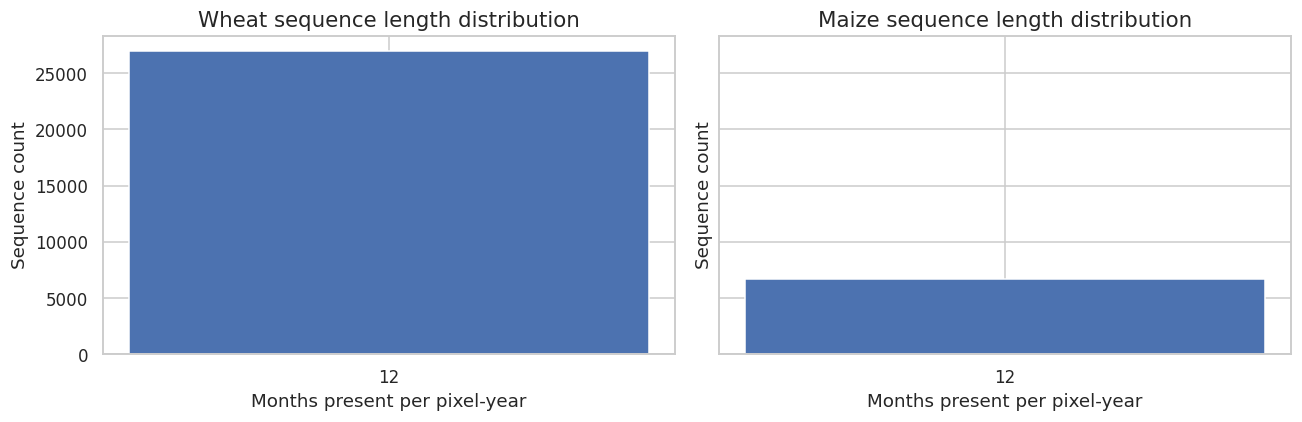

In [5]:
fig, axes = plt.subplots(1, len(analysis), figsize=(6 * len(analysis), 4), sharey=True)
if len(analysis) == 1:
    axes = [axes]
for ax, (crop, info) in zip(axes, analysis.items()):
    hist = info["seq_hist"]
    ax.bar(hist["n_months"], hist["num_sequences"], color="#4C72B0")
    ax.set_xticks(hist["n_months"].tolist())
    ax.set_xlabel("Months present per pixel-year")
    ax.set_ylabel("Sequence count")
    ax.set_title(f"{crop.capitalize()} sequence length distribution")
plt.tight_layout()
plt.show()

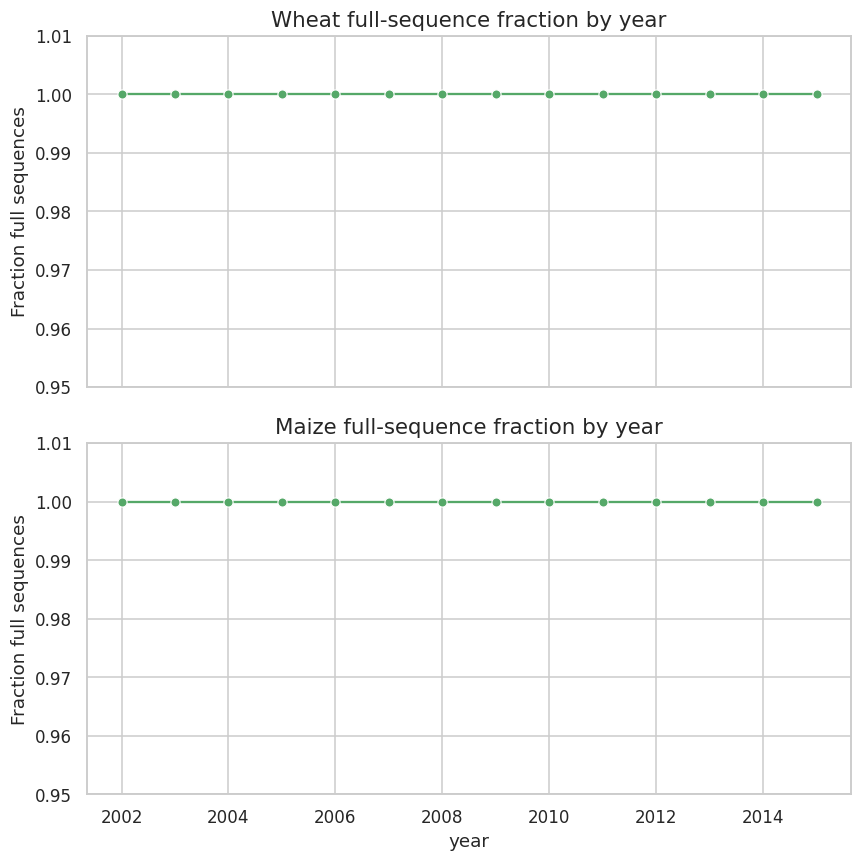

In [6]:
fig, axes = plt.subplots(len(analysis), 1, figsize=(8, 4 * len(analysis)), sharex=True)
if len(analysis) == 1:
    axes = [axes]
for ax, (crop, info) in zip(axes, analysis.items()):
    data = info["seq_year"].copy()
    data["full_fraction"] = data["full_sequences"] / data["total_sequences"]
    sns.lineplot(data=data, x="year", y="full_fraction", marker="o", ax=ax, color="#55A868")
    ax.set_ylim(0.95, 1.01)
    ax.set_ylabel("Fraction full sequences")
    ax.set_title(f"{crop.capitalize()} full-sequence fraction by year")
plt.tight_layout()
plt.show()

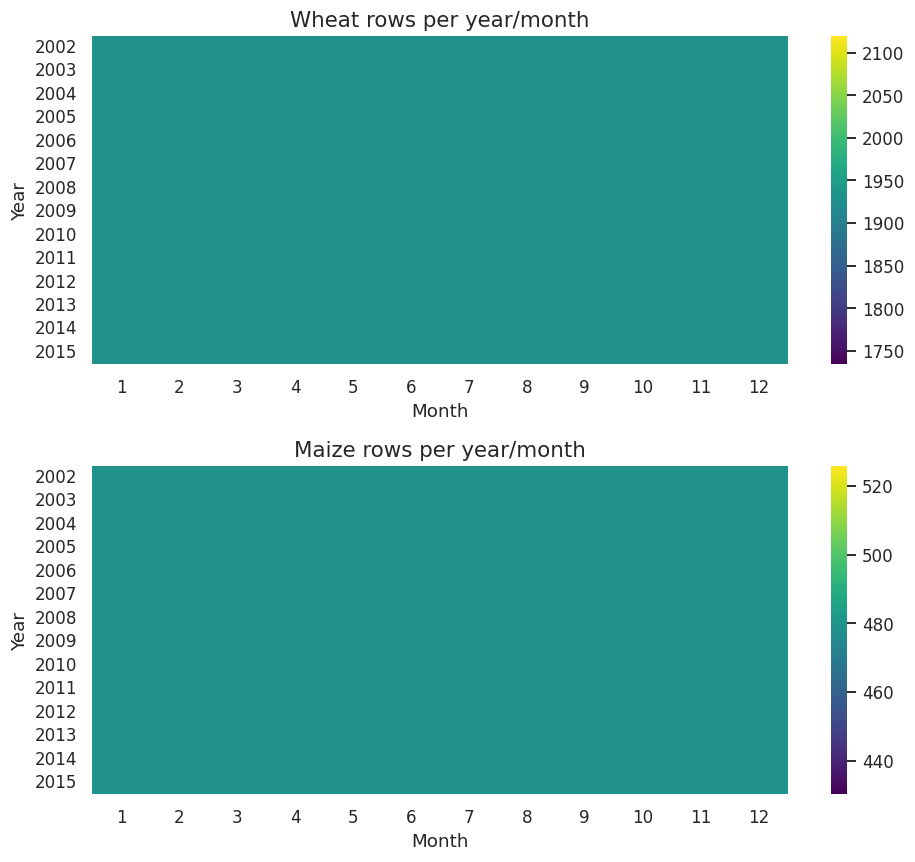

In [7]:
fig, axes = plt.subplots(len(analysis), 1, figsize=(9, 4 * len(analysis)))
if len(analysis) == 1:
    axes = [axes]
for ax, (crop, info) in zip(axes, analysis.items()):
    heat = info["month_year_counts"].pivot(index="year", columns="month", values="row_count")
    sns.heatmap(heat, cmap="viridis", ax=ax)
    ax.set_title(f"{crop.capitalize()} rows per year/month")
    ax.set_xlabel("Month")
    ax.set_ylabel("Year")
plt.tight_layout()
plt.show()

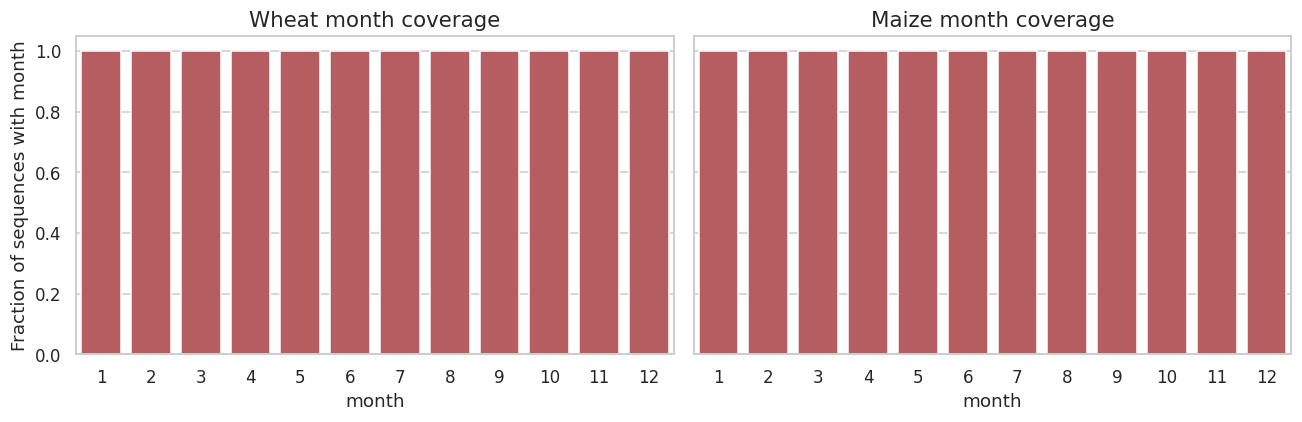

In [8]:
fig, axes = plt.subplots(1, len(analysis), figsize=(6 * len(analysis), 4), sharey=True)
if len(analysis) == 1:
    axes = [axes]
for ax, (crop, info) in zip(axes, analysis.items()):
    data = info["month_presence"].copy()
    sns.barplot(data=data, x="month", y="fraction", ax=ax, color="#C44E52")
    ax.set_ylim(0.0, 1.05)
    ax.set_ylabel("Fraction of sequences with month")
    ax.set_title(f"{crop.capitalize()} month coverage")
plt.tight_layout()
plt.show()

/tmp/ipykernel_40317/2540519044.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="fraction_missing", y="feature", ax=ax, palette="Blues_r")
/tmp/ipykernel_40317/2540519044.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="fraction_missing", y="feature", ax=ax, palette="Blues_r")


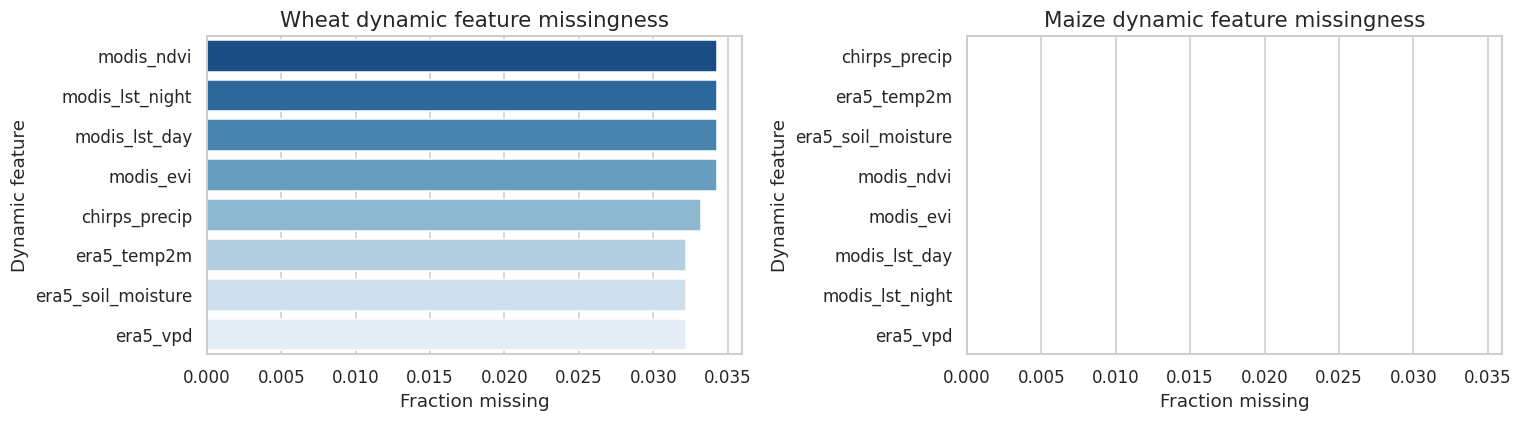

In [9]:
fig, axes = plt.subplots(1, len(analysis), figsize=(7 * len(analysis), 4), sharex=True)
if len(analysis) == 1:
    axes = [axes]
for ax, (crop, info) in zip(axes, analysis.items()):
    data = info["dynamic_missing"].copy()
    sns.barplot(data=data, x="fraction_missing", y="feature", ax=ax, palette="Blues_r")
    ax.set_xlabel("Fraction missing")
    ax.set_ylabel("Dynamic feature")
    ax.set_title(f"{crop.capitalize()} dynamic feature missingness")
plt.tight_layout()
plt.show()

/tmp/ipykernel_40317/1351732486.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="fraction_missing", y="feature", ax=ax, palette="Greens_r")
/tmp/ipykernel_40317/1351732486.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="fraction_missing", y="feature", ax=ax, palette="Greens_r")


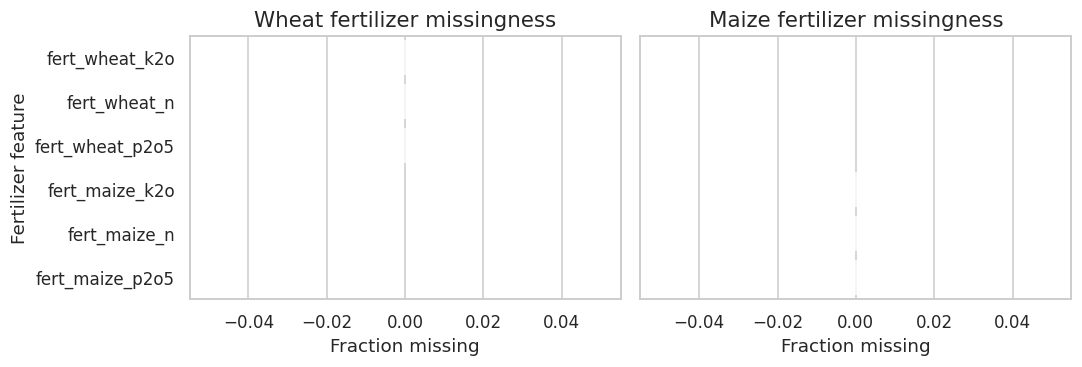

In [10]:
fig, axes = plt.subplots(1, len(analysis), figsize=(5 * len(analysis), 3.5), sharey=True)
if len(analysis) == 1:
    axes = [axes]
for ax, (crop, info) in zip(axes, analysis.items()):
    data = info["fert_missing"].copy()
    sns.barplot(data=data, x="fraction_missing", y="feature", ax=ax, palette="Greens_r")
    ax.set_xlabel("Fraction missing")
    ax.set_ylabel("Fertilizer feature")
    ax.set_title(f"{crop.capitalize()} fertilizer missingness")
plt.tight_layout()
plt.show()

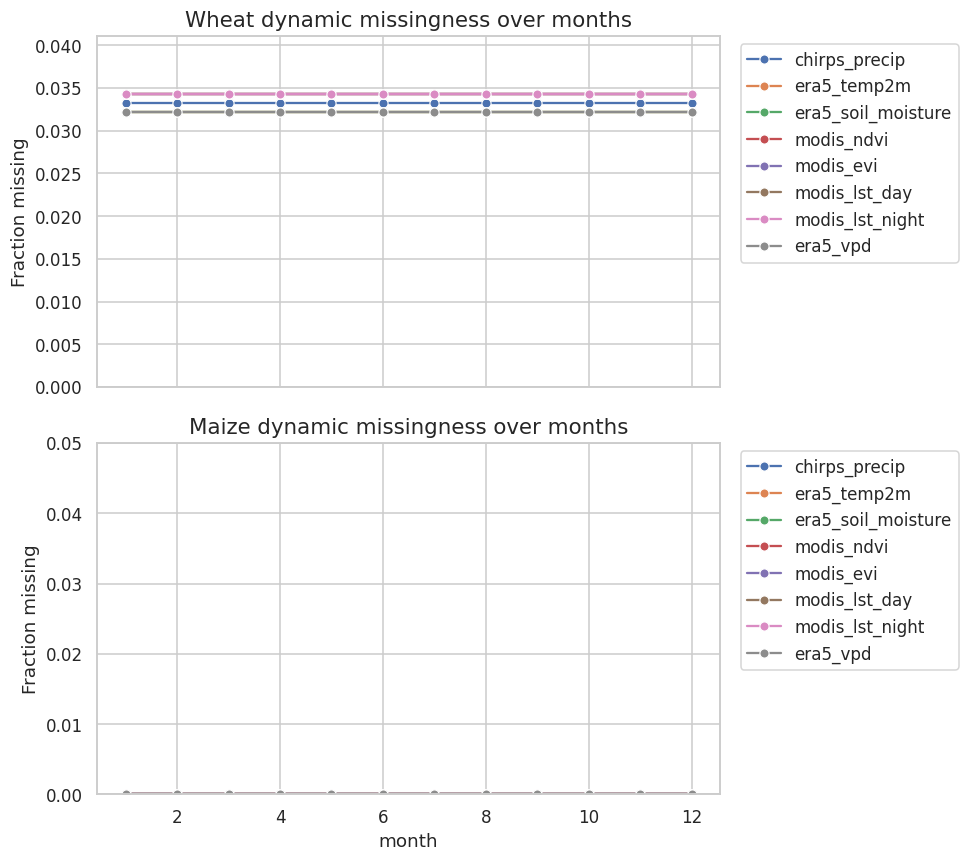

In [11]:
fig, axes = plt.subplots(len(analysis), 1, figsize=(9, 4 * len(analysis)), sharex=True)
if len(analysis) == 1:
    axes = [axes]
for ax, (crop, info) in zip(axes, analysis.items()):
    data = info["dynamic_missing_by_month"].copy()
    long = data.melt(id_vars="month", var_name="metric", value_name="fraction_missing")
    long["feature"] = long["metric"].str.replace("miss_", "", regex=False)
    sns.lineplot(data=long, x="month", y="fraction_missing", hue="feature", marker="o", ax=ax)
    ymax = long["fraction_missing"].max()
    ax.set_ylim(0, ymax * 1.2 if ymax > 0 else 0.05)
    ax.set_ylabel("Fraction missing")
    ax.set_title(f"{crop.capitalize()} dynamic missingness over months")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

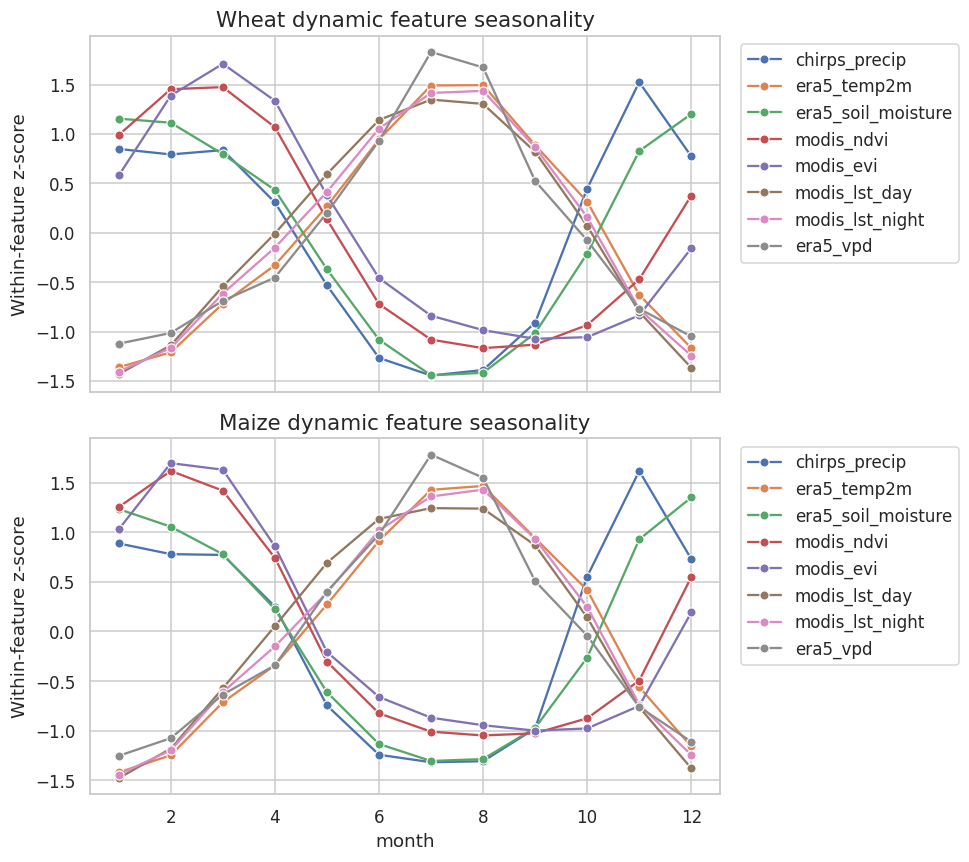

In [12]:
fig, axes = plt.subplots(len(analysis), 1, figsize=(9, 4 * len(analysis)), sharex=True)
if len(analysis) == 1:
    axes = [axes]
for ax, (crop, info) in zip(axes, analysis.items()):
    means = info["monthly_means"].copy()
    feature_cols = [c for c in means.columns if c.startswith("avg_") and c != "avg_yield"]
    long = means.melt(id_vars="month", value_vars=feature_cols, var_name="metric", value_name="value")
    long["feature"] = long["metric"].str.replace("avg_", "", regex=False)

    def _zscore(group):
        std = group.std(ddof=0)
        return (group - group.mean()) / std if std else group * 0

    long["zscore"] = long.groupby("feature")["value"].transform(_zscore)
    sns.lineplot(data=long, x="month", y="zscore", hue="feature", marker="o", ax=ax)
    ax.set_ylabel("Within-feature z-score")
    ax.set_title(f"{crop.capitalize()} dynamic feature seasonality")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

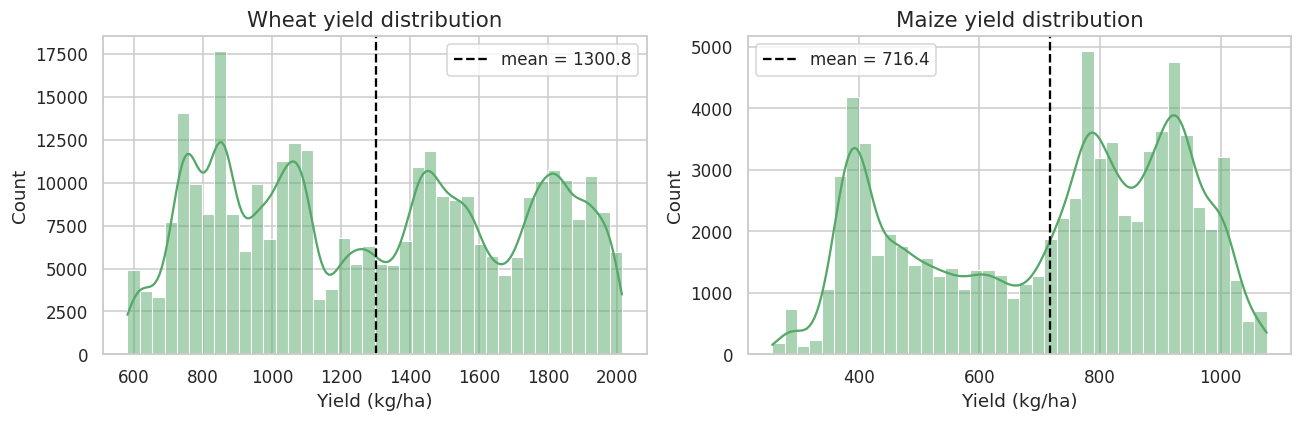

In [13]:
fig, axes = plt.subplots(1, len(analysis), figsize=(6 * len(analysis), 4))
if len(analysis) == 1:
    axes = [axes]
for ax, (crop, info) in zip(axes, analysis.items()):
    con = duckdb.connect()
    yield_df = con.execute(
        f"SELECT {info['target_col']} AS target FROM read_parquet(?)",
        [str(info["path"])],
    ).df()
    sns.histplot(yield_df["target"], bins=40, kde=True, color="#55A868", ax=ax)
    stats = info["target_stats"].iloc[0]
    ax.axvline(stats["mean"], color="black", linestyle="--", label=f"mean = {stats['mean']:.1f}")
    ax.set_title(f"{crop.capitalize()} yield distribution")
    ax.set_xlabel("Yield (kg/ha)")
    ax.legend()
plt.tight_layout()
plt.show()

In [14]:
for crop, info in analysis.items():
    display(Markdown(f"### Example sequence — {crop.capitalize()} (pixel {info['example_key'][0]}, year {info['example_key'][1]})"))
    display(info["example_df"])

### Example sequence — Wheat (pixel 1179658, year 2002)

,month,chirps_precip,era5_temp2m,era5_soil_moisture,modis_ndvi,modis_evi,modis_lst_day,modis_lst_night,era5_vpd,yield_wheat,fert_wheat_k2o,fert_wheat_n,fert_wheat_p2o5
0,1,37.5270,13.0826,0.3010,0.5597,0.3020,15.8015,9.2172,0.3253,1908.766,0.1525,0.9737,0.9346
1,2,20.4101,13.2038,0.2548,0.5726,0.3019,17.8616,9.6664,0.3280,1908.766,0.1525,0.9737,0.9346
2,3,131.1305,14.1431,0.3013,0.5658,0.3115,17.4165,8.9475,0.3995,1908.766,0.1525,0.9737,0.9346
3,4,92.2377,15.3550,0.3035,0.6037,0.3762,22.3277,12.6384,0.4787,1908.766,0.1525,0.9737,0.9346
4,5,29.4564,17.0527,0.1861,0.5794,0.3446,25.1310,13.2405,0.6443,1908.766,0.1525,0.9737,0.9346
5,6,0.1433,20.5977,0.1483,0.4593,0.2970,29.2040,16.3553,0.7926,1908.766,0.1525,0.9737,0.9346
6,7,0.0000,22.9538,0.1272,0.3861,0.2330,32.9416,19.2333,0.9092,1908.766,0.1525,0.9737,0.9346
7,8,0.0000,22.4505,0.1272,0.3703,0.2092,32.6591,18.4128,0.8093,1908.766,0.1525,0.9737,0.9346
8,9,31.2442,20.8546,0.1835,0.3737,0.2033,28.0432,17.4357,0.5535,1908.766,0.1525,0.9737,0.9346
9,10,90.1365,18.6608,0.2655,0.4858,0.2611,20.9374,14.3909,0.3958,1908.766,0.1525,0.9737,0.9346


### Example sequence — Maize (pixel 732532, year 2002)

,month,chirps_precip,era5_temp2m,era5_soil_moisture,modis_ndvi,modis_evi,modis_lst_day,modis_lst_night,era5_vpd,yield_maize,fert_maize_k2o,fert_maize_n,fert_maize_p2o5
0,1,37.6056,13.9194,0.2341,0.4006,0.2288,19.6648,9.5544,0.3456,873.428,0.3838,1.1345,1.2466
1,2,17.0703,14.1645,0.1693,0.4316,0.2503,23.2412,9.5992,0.3563,873.428,0.3838,1.1345,1.2466
2,3,68.6753,15.4577,0.2432,0.4505,0.2709,22.4751,11.0882,0.4457,873.428,0.3838,1.1345,1.2466
3,4,108.9963,16.4669,0.2640,0.4375,0.2894,27.2201,13.5184,0.5095,873.428,0.3838,1.1345,1.2466
4,5,9.0318,17.8655,0.1368,0.3929,0.2319,31.4212,13.8865,0.6045,873.428,0.3838,1.1345,1.2466
5,6,0.0000,20.7082,0.1103,0.2840,0.1837,35.2914,16.2109,0.7358,873.428,0.3838,1.1345,1.2466
6,7,0.0000,22.5859,0.1078,0.2585,0.1716,36.9902,19.0747,0.7649,873.428,0.3838,1.1345,1.2466
7,8,0.0000,22.1484,0.1080,0.2567,0.1648,37.2468,18.2356,0.6953,873.428,0.3838,1.1345,1.2466
8,9,3.9285,21.6798,0.1105,0.2569,0.1562,34.0376,18.0258,0.6136,873.428,0.3838,1.1345,1.2466
9,10,56.4458,20.1389,0.2245,0.2981,0.1836,27.1674,15.3475,0.4763,873.428,0.3838,1.1345,1.2466


In [15]:
if analysis:
    summary_lines = []
    for crop, info in analysis.items():
        seq_hist = info["seq_hist"]
        min_months = int(seq_hist["n_months"].min()) if not seq_hist.empty else 0
        max_months = int(seq_hist["n_months"].max()) if not seq_hist.empty else 0
        if not seq_hist.empty and (seq_hist["n_months"] == 12).any():
            full_fraction = (
                float(seq_hist.loc[seq_hist["n_months"] == 12, "num_sequences"].iloc[0])
                / info["total_sequences"]
            )
        else:
            full_fraction = float("nan")
        dyn_missing_mean = (
            info["dynamic_missing"]["fraction_missing"].mean()
            if not info["dynamic_missing"].empty
            else float("nan")
        )
        summary_lines.append(
            f"- **{crop.capitalize()}**: {info['total_sequences']:,} sequences covering {min_months}–{max_months} months; full-coverage fraction = {full_fraction:.3f}. Average dynamic missingness {dyn_missing_mean:.2%}."
        )
    summary_lines.append(
        "- No pixel-year in either crop falls below 12 observations, so the zero-padding/truncation branch in `MonthlySequenceDataset` never triggers on the current datasets."
    )
    display(Markdown("\n".join(summary_lines)))
else:
    display(Markdown("No datasets were loaded."))

- **Wheat**: 26,978 sequences covering 12–12 months; full-coverage fraction = 1.000. Average dynamic missingness 3.33%.
- **Maize**: 6,692 sequences covering 12–12 months; full-coverage fraction = 1.000. Average dynamic missingness 0.00%.
- No pixel-year in either crop falls below 12 observations, so the zero-padding/truncation branch in `MonthlySequenceDataset` never triggers on the current datasets.